# Cравнение детекторов на примере детекции игроков в спорте

Требуется обучить на целевом датасете (игроки в спорте) два типа детекторов: 
1) Detectron2 (семейтсво R-CNN)
2) Ultralytics (семейство YOLO). 

После обучения необходимо замерить метрику mAP для разных моделей и сравнить результаты.

Импортируем все требуемые зависимости

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

import ultralytics
ultralytics.checks()
from ultralytics import YOLO

import matplotlib.pyplot as plt
from IPython.display import Image

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
Setup complete ✅ (8 CPUs, 94.3 GB RAM, 74.4/98.4 GB disk)


Установим нужные пакеты

In [2]:
!python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git' --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!python3 -m pip install ultralytics  --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


## 0. Подготовка датасета

Требуется подготовить датасет для использования в детекторах в форматах, принятых в Detectron и YOLO 

Для начала распакуем датасет

In [4]:
! unzip -qq otus_basketball_dataset.zip -d datasets

In [5]:
DATASET_PATH = 'datasets/otus_basketball_dataset'

### Данные для Detectron2
Зарегистрируем датасет в detectron2, приведя формат к внутреннему формату датасетов detectron2.

Режим XYWH_REL пока не поддержан, поэтому приводим координаты к абсолютным значениям

In [6]:
def get_basketball_dict(split):
    img_dir = f'{DATASET_PATH}/images_{split}'
    ann_file = f'{DATASET_PATH}/anno_{split}.json'

    with open(ann_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, (filename, annos) in enumerate(imgs_anns.items()):
        record = {}

        filename = os.path.join(img_dir, filename)
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for anno in annos.values():
            x, y, w, h = anno['box']
            objs.append({
                "bbox": [int(x * width), int(y * height), int(w * width), int(h * height)],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": anno['team'],
            })
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for split in ["train", "test"]:
    DatasetCatalog.register(f'basketball_{split}', lambda split=split: get_basketball_dict(split))
    MetadataCatalog.get(f'basketball_{split}').set(thing_classes=["team_0", "team_1"])
basketball_metadata = MetadataCatalog.get("basketball_train")

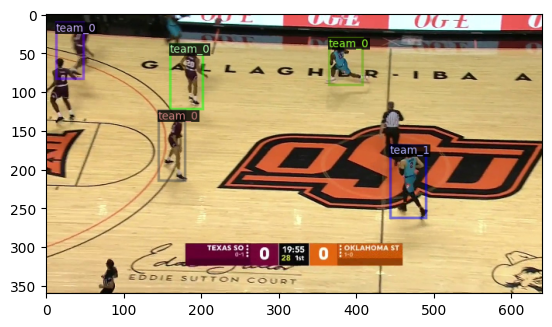

In [7]:
dataset_dict = get_basketball_dict("train")[0]
img = cv2.imread(dataset_dict["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=basketball_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(dataset_dict)
plt.imshow(out.get_image())
plt.show()    

### Данные для YOLO

Кладем рядом с картинками csv-like текстовые файлики с координатами bounding box (cx, cy, w, h)

In [8]:
def write_basketball_annotations(split):
    img_dir = f'{DATASET_PATH}/images_{split}'
    ann_file = f'{DATASET_PATH}/anno_{split}.json'

    with open(ann_file) as f:
        imgs_anns = json.load(f)

    for idx, (filename, annos) in enumerate(imgs_anns.items()):

        filename = os.path.join(img_dir, filename)
        
        data = ''
        for anno in annos.values():
            x, y, w, h = anno['box']
            x = x + w / 2
            y = y + h / 2
            team = anno['team']
            data += f'{team} {x} {y} {w} {h}\n'
        
        with open(filename.replace('.jpeg', '.txt'), 'w') as file:
            file.write(data)
        
write_basketball_annotations('test')
write_basketball_annotations('train')

Посмотрим на получившийся файл

In [9]:
! cat $(find datasets/otus_basketball_dataset/images_train/*.txt | head -n 1)

0 0.2831999138956394 0.22685930410703592 0.0671472597220639 0.23091108578361821
0 0.25295843786531963 0.473427895635562 0.052639411719238895 0.24951755651285445
1 0.7297929394056469 0.6035976676486935 0.0732743736875129 0.26080628961483754
0 0.6042365068621496 0.17366055489147025 0.06753896019904879 0.16664101780646795
0 0.04764704296986262 0.13567299313015407 0.05414966499252986 0.20089679859302662


Создадим файл конфигурации для YOLO

In [11]:
! touch otus_basketball_dataset.yaml
! echo "path: otus_basketball_dataset/" > otus_basketball_dataset.yaml
! echo "train: 'images_train'" >> otus_basketball_dataset.yaml
! echo "val: 'images_test'" >> otus_basketball_dataset.yaml
! echo "names: " >> otus_basketball_dataset.yaml
! echo "  0: 'team_0'" >> otus_basketball_dataset.yaml
! echo "  1: 'team_1'" >> otus_basketball_dataset.yaml
! cat otus_basketball_dataset.yaml

path: otus_basketball_dataset/
train: 'images_train'
val: 'images_test'
names: 
  0: 'team_0'
  1: 'team_1'


## 1. Модель из Detectron2

В качестве начальной модели берем предобученный Faster R-CNN. В конце посчитаем метрику COCO mAP.

In [12]:
MODEL_NAME = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_NAME))

cfg.DATASETS.TRAIN = ("basketball_train",)
cfg.DATASETS.TEST = ("basketball_test",)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_NAME) 
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [13]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/02 18:01:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[06/02 18:01:24 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/02 18:02:09 d2.utils.events]:  eta: 0:09:14  iter: 19  total_loss: 0.9548  loss_cls: 0.4552  loss_box_reg: 0.3569  loss_rpn_cls: 0.04952  loss_rpn_loc: 0.03066    time: 1.9821  last_time: 1.9937  data_time: 0.1920  last_data_time: 0.1693   lr: 0.0012854  max_mem: 24155M
[06/02 18:03:07 d2.utils.events]:  eta: 0:08:41  iter: 39  total_loss: 0.9854  loss_cls: 0.38  loss_box_reg: 0.565  loss_rpn_cls: 0.01758  loss_rpn_loc: 0.02425    time: 2.0127  last_time: 2.0030  data_time: 0.1863  last_data_time: 0.1594   lr: 0.0026174  max_mem: 24155M
[06/02 18:03:48 d2.utils.events]:  eta: 0:08:02  iter: 59  total_loss: 0.9708  loss_cls: 0.4052  loss_box_reg: 0.5422  loss_rpn_cls: 0.00837  loss_rpn_loc: 0.02267    time: 2.0150  last_time: 2.0580  data_time: 0.1751  last_data_time: 0.1996   lr: 0.0039494  max_mem: 24155M
[06/02 18:04:28 d2.utils.events]:  eta: 0:07:23  iter: 79  total_loss: 0.8255  loss_cls: 0.4027  loss_box_reg: 0.4012  loss_rpn_cls: 0.006101  loss_rpn_loc: 0.02042    time: 2.01

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[06/02 18:12:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Взглянем на результат детектирования

{'instances': Instances(num_instances=11, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[464.6812,  59.4790, 539.2344, 161.8595],
        [490.2100, 221.2246, 566.0042, 350.7267],
        [374.6450, 439.9931, 455.5616, 589.3253],
        [343.6224, 516.1815, 426.4615, 684.6213],
        [410.5750, 194.0010, 481.5264, 329.2275],
        [462.6234, 251.3041, 525.8793, 368.4749],
        [275.0790, 207.0668, 382.2901, 342.5657],
        [112.3535, 142.9517, 178.4916, 258.4778],
        [475.2282, 140.6469, 549.4847, 261.8626],
        [543.3244, 190.3903, 607.2291, 303.7043],
        [455.3534,  37.0366, 514.0602, 118.7839]], device='cuda:0')), scores: tensor([0.9537, 0.9445, 0.9271, 0.9232, 0.9215, 0.9181, 0.8954, 0.8925, 0.8751, 0.8546, 0.5976], device='cuda:0'), pred_classes: tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')])}


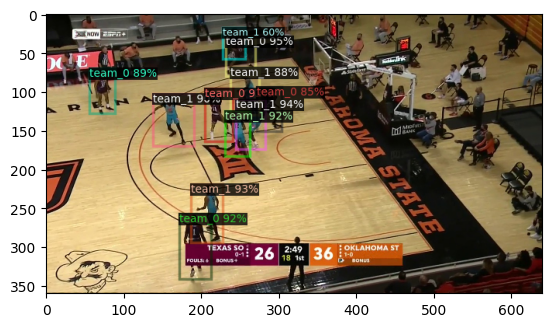

In [15]:
dataset_dict = get_basketball_dict("test")[0]
img = cv2.imread(dataset_dict["file_name"])
outputs = predictor(img)
print(outputs)
visualizer = Visualizer(img[:, :, ::-1],
                   metadata=basketball_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE
    )
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
plt.show()    

Посмотрим на кривые обучения

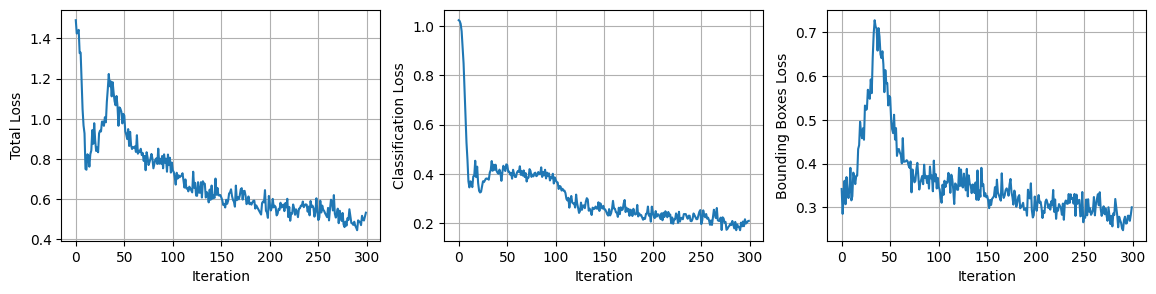

In [16]:
def show_loss_history(trainer):
    fig = plt.figure(figsize=(14, 3))
    
    plt.subplot(131)
    plt.plot([item[0] for item in trainer.storage.history('total_loss').values()])
    plt.xlabel("Iteration")
    plt.ylabel("Total Loss")
    plt.grid(True)
    
    plt.subplot(132)
    plt.plot([item[0] for item in trainer.storage.history('loss_cls').values()])
    plt.xlabel("Iteration")
    plt.ylabel("Classification Loss")
    plt.grid(True)
    
    plt.subplot(133)
    plt.plot([item[0] for item in trainer.storage.history('loss_box_reg').values()])
    plt.xlabel("Iteration")
    plt.ylabel("Bounding Boxes Loss")
    plt.grid(True)
        

    plt.show()

show_loss_history(trainer)

In [17]:
evaluator = COCOEvaluator("basketball_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "basketball_test")
metrics_faster_rcnn = inference_on_dataset(predictor.model, test_loader, evaluator)

[06/02 18:13:00 d2.evaluation.coco_evaluation]: Trying to convert 'basketball_test' to COCO format ...
[06/02 18:13:00 d2.data.datasets.coco]: Converting annotations of dataset 'basketball_test' to COCO format ...)
[06/02 18:13:01 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/02 18:13:01 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 660
[06/02 18:13:01 d2.data.datasets.coco]: Caching COCO format annotations at './output/basketball_test_coco_format.json' ...
[06/02 18:13:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/02 18:13:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/02 18:13:03 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[06/02 18:13:03 d2.data.common]: Serialized dataset takes 0.04 MiB
[06/02 18:13:03 d2

## 2. Модель из Ultralytics 

В качестве начальной модели возьмем YOLOv8. Посчитаем метрику COCO mAP.

In [18]:
model = YOLO("yolov8n.pt")

In [19]:
train_results = model.train(data="otus_basketball_dataset.yaml", epochs=10, batch=16, imgsz=640, task="detect")

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=otus_basketball_dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_train... 400 images, 0 backgrounds, 1 corrupt: 100%|██████████| 400/400 [00:00<00:00, 824.84it/s]

train: WARNING ⚠️ /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_train/052768.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0118]
train: New cache created: /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_test... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 566.63it/s]

val: New cache created: /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_test.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      30.5G      1.687      2.713      1.227         97        640: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        660     0.0199      0.908      0.176       0.06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       4.1G      1.461      1.718      1.136        100        640: 100%|██████████| 25/25 [00:03<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]

                   all        100        660     0.0214       0.97      0.415      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.11G      1.454      1.422       1.14        110        640: 100%|██████████| 25/25 [00:03<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]

                   all        100        660      0.675      0.453      0.599      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.11G      1.407      1.323       1.11         99        640: 100%|██████████| 25/25 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]

                   all        100        660      0.643      0.746      0.646      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.11G       1.39      1.238      1.104         90        640: 100%|██████████| 25/25 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        100        660       0.62      0.802      0.667      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.11G      1.353        1.2      1.094         96        640: 100%|██████████| 25/25 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        100        660      0.668      0.842      0.663      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.11G      1.326      1.137      1.065         93        640: 100%|██████████| 25/25 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]

                   all        100        660       0.67      0.857      0.684      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.11G      1.287      1.101      1.064         94        640: 100%|██████████| 25/25 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        100        660      0.669      0.872      0.686      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.11G      1.299      1.083      1.048         97        640: 100%|██████████| 25/25 [00:02<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]

                   all        100        660      0.665      0.876      0.684       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.11G      1.273      1.049      1.044        103        640: 100%|██████████| 25/25 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        100        660      0.673      0.877      0.677      0.407



10 epochs completed in 0.016 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


                   all        100        660      0.665      0.876      0.683       0.41
                team_0        100        377      0.745      0.862      0.744      0.455
                team_1        100        283      0.585       0.89      0.623      0.364
Speed: 1.3ms preprocess, 0.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


Взглянем на результат детекции

In [20]:
results = model.predict(dataset_dict["file_name"], imgsz=640)


image 1/1 /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_test/078176.jpeg: 384x640 5 team_0s, 5 team_1s, 73.1ms
Speed: 1.5ms preprocess, 73.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


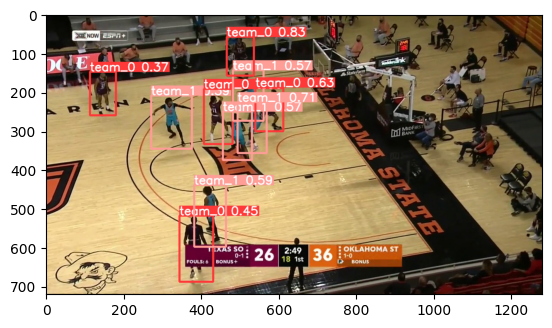

In [21]:
img = results[0].plot()
plt.imshow(img[:, :, ::-1])
plt.show()   

Откроем сохраненные кривые обучения

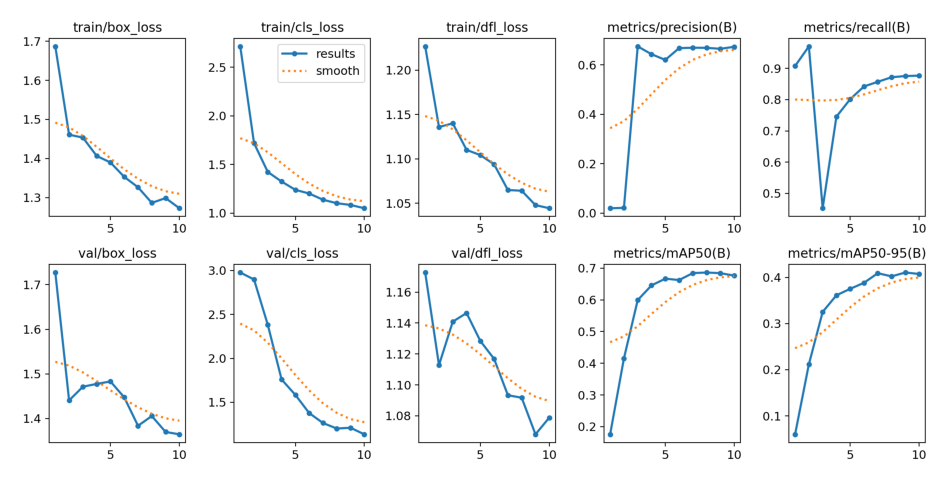

In [22]:
img = cv2.imread('runs/detect/train/results.png')
plt.figure(figsize=(12, 12))
plt.imshow(img[:, :, ::-1])
plt.axis('off')
plt.show()  

In [23]:
metrics_pretrained = model.val()

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)


val: Scanning /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_test.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


                   all        100        660      0.665      0.876      0.684      0.411
                team_0        100        377      0.745      0.861      0.744      0.457
                team_1        100        283      0.585       0.89      0.623      0.366
Speed: 1.3ms preprocess, 3.2ms inference, 0.0ms loss, 60.2ms postprocess per image
Results saved to runs/detect/train2


## 3. Обучение модели из Ultralytics с нуля

Увеличим количество эпох, так как обучаем модель с нуля

In [24]:
model = YOLO("yolov8n.yaml")

In [25]:
train_results = model.train(data="otus_basketball_dataset.yaml", epochs=20, batch=16, imgsz=640, task="detect")

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=otus_basketball_dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

train: Scanning /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_train.cache... 400 images, 0 backgrounds, 1 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_train/052768.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0118]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_test.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.22G      5.644      4.416      4.125        159        640: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        100        660          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.13G      4.047      3.238      3.638        183        640: 100%|██████████| 25/25 [00:03<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        100        660          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.13G      2.879      2.399       2.73        199        640: 100%|██████████| 25/25 [00:03<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all        100        660          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.13G      2.511      2.101      2.294        210        640: 100%|██████████| 25/25 [00:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


                   all        100        660   0.000728     0.0371    0.00697    0.00261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.13G      2.349       1.87      2.058        177        640: 100%|██████████| 25/25 [00:03<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

                   all        100        660      0.463      0.331      0.332      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.13G      2.239      1.724      1.934        166        640: 100%|██████████| 25/25 [00:03<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

                   all        100        660      0.417      0.523      0.394      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.13G      2.183      1.669       1.89        201        640: 100%|██████████| 25/25 [00:02<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

                   all        100        660      0.379      0.624      0.428       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.13G       2.11      1.573      1.824        199        640: 100%|██████████| 25/25 [00:03<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

                   all        100        660      0.523      0.598      0.474      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.13G      2.108      1.484      1.784        187        640: 100%|██████████| 25/25 [00:03<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

                   all        100        660      0.621       0.77      0.607      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.13G       2.03      1.458      1.742        168        640: 100%|██████████| 25/25 [00:03<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

                   all        100        660      0.583      0.777      0.621       0.27


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.13G      1.866      1.546      1.734         96        640: 100%|██████████| 25/25 [00:07<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]

                   all        100        660      0.549       0.69      0.506      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.13G      1.846      1.437      1.726        108        640: 100%|██████████| 25/25 [00:03<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]

                   all        100        660      0.628      0.788      0.603      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.13G      1.817      1.377      1.701         99        640: 100%|██████████| 25/25 [00:03<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

                   all        100        660      0.631      0.797      0.627      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.13G      1.804      1.367      1.672        102        640: 100%|██████████| 25/25 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

                   all        100        660      0.636      0.803      0.626      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.13G      1.805      1.355      1.672         98        640: 100%|██████████| 25/25 [00:02<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

                   all        100        660      0.626      0.763      0.592      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.13G      1.794      1.312       1.64         96        640: 100%|██████████| 25/25 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all        100        660      0.637      0.835      0.644      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.13G      1.759      1.324      1.654        101        640: 100%|██████████| 25/25 [00:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


                   all        100        660      0.653       0.84       0.64      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.13G      1.758      1.304      1.659         95        640: 100%|██████████| 25/25 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        100        660      0.642      0.835      0.623      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.13G      1.752      1.295      1.612         90        640: 100%|██████████| 25/25 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

                   all        100        660      0.641      0.838      0.643      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.13G      1.743      1.282      1.597        101        640: 100%|██████████| 25/25 [00:02<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.64it/s]

                   all        100        660      0.642      0.831      0.643      0.311



20 epochs completed in 0.040 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


                   all        100        660      0.642       0.83      0.643      0.311
                team_0        100        377      0.723      0.784      0.722      0.364
                team_1        100        283      0.561      0.876      0.563      0.258
Speed: 1.3ms preprocess, 0.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train3


In [26]:
metrics_from_scratch = model.val()

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_test.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


                   all        100        660      0.643      0.829      0.644      0.311
                team_0        100        377      0.723      0.782      0.725      0.364
                team_1        100        283      0.562      0.875      0.564      0.258
Speed: 1.3ms preprocess, 1.4ms inference, 0.0ms loss, 22.7ms postprocess per image
Results saved to runs/detect/train32


Откроем сохраненные кривые обучения

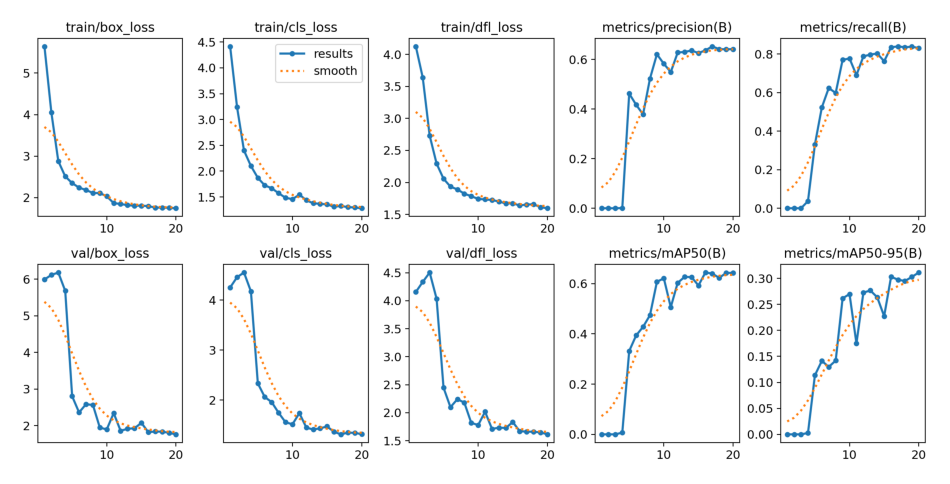

In [28]:
img = cv2.imread('runs/detect/train3/results.png')
plt.figure(figsize=(12, 12))
plt.imshow(img[:, :, ::-1])
plt.axis('off')
plt.show()  

## 4. Ultralytics модель "из коробки"

Посмотрим на результаты модели без дообучения

In [29]:
model = YOLO("yolov8n.pt")

In [30]:
metrics_default_model = model.val(data="otus_basketball_dataset.yaml")

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /home/jupyter/work/resources/detectors/datasets/otus_basketball_dataset/images_test.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


                   all        100        660      0.114      0.298      0.113     0.0434
                person        100        377      0.229      0.595      0.205     0.0773
               bicycle        100        283          0          0     0.0205    0.00957
Speed: 1.3ms preprocess, 2.6ms inference, 0.0ms loss, 46.0ms postprocess per image
Results saved to runs/detect/val


## 5. Итоги

Сведем результаты в таблицу и подведём итоги

In [62]:
from tabulate import tabulate

data = [['Faster R-CNN', 0, 0]]
data = [
    ['Faster R-CNN', list(metrics_faster_rcnn.items())[0][1]['AP50']/100, list(metrics_faster_rcnn.items())[0][1]['AP75']/100],
    ['YOLO pretrained', metrics_pretrained.box.map50, metrics_pretrained.box.map75],
    ['YOLO from scratch', metrics_from_scratch.box.map50, metrics_from_scratch.box.map75],
    ['YOLO default', metrics_default_model.box.map50, metrics_default_model.box.map75]
]

print(tabulate(data, headers=['model', 'mAP50', 'mAP75']))

model                 mAP50     mAP75
-----------------  --------  --------
Faster R-CNN       0.660409  0.451473
YOLO pretrained    0.683729  0.45815
YOLO from scratch  0.644342  0.247347
YOLO default       0.112785  0.022355


### Касательно методологии сравнения

Думаю, имеет смысл фиксировать какой-то параметр при сравнении моделей, тогда это сравнение приобретает смысл. Например:
- лучший результат при N fps инференсе на аналогичном железе
- лучший результат при времени обучения менее N на аналогичном железе

В данном сравнении можно сказать, что зафиксированы настройки. Результаты отражают точность выбранных реализаций при условно дефолтных настройках. Грубо говоря, кто даст лучший результат, если взять модель "как есть" и дообучить на своих данных. 


### Касательно самих моделей

Faster R-CNN - более точная и медленная модель по сравнению с YOLOv8. Она хорошо подходит для задач, где требуется высокая точность обнаружения объектов, даже если это означает более высокую вычислительную стоимость.

YOLO - более быстрая и менее точная модель по сравнению с Faster R-CNN. Она хорошо подходит для задач, где требуется быстрое обнаружение объектов в реальном времени или при работе с большими объемами данных.

Результаты это подтверждают: на порядок более "тяжелый" Faster R-CNN значительно дольше обучается и в итоге медленнее работает. При этом выдавая из коробки худший относительно YOLO результат. Вероятно, требуется больше внимания к гипер-параметрам, чтобы выжать из модели максимум. 

Faster R-CNN следует использовать, когда требуется высокая точность обнаружения объектов (скорость при этом уходит на второй план), например, при анализе медицинских изображений или аутентификации по лицу.

YOLO следует использовать, когда требуется быстрое обнаружение объектов, например, в системах видеонаблюдения или автопилотах. Здесь на второй план уходит точность, когда без возможности работы в режиме реального времени о применении модели в принципе не идет речи.

### Касательно использования предобученных весов

Результаты подтверждают тезис, озвученный на занятии: в 99% случаев следует использовать предобученные модели. Так как специализация модели дается гораздо проще выделения самых важных низкоуровневых признаков, на выделение которых ушли огромные датасеты и дни обучения. Оставшийся 1% - задачи совсем уж специальной доменной области, примеров которой почти не найти в публичных датасетах. 

И второй момент - дообучение стоит делать всегда, когда данные хоть сколько нибудь отличаются от использовавшихся при обучении исходных весов доступных моделей. В нашем случае мы использовали вообще иные от исходных классы (разделение по командам), поэтому дообучение - необходимый шаг. 